In [68]:
# filter all the warnings
import warnings
warnings.filterwarnings("ignore")

# data manipulation tools
import pandas as pd
import pandas
import numpy as np

# modeling tools
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import xgboost as xgb
import lightgbm as lgb
from optuna import Trial
from sklearn.metrics import f1_score
import torch
from pytorch_tabnet.tab_model import TabNetClassifier
# from torchvision import transforms
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, random_split
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data.sampler import SubsetRandomSampler
from autogluon.tabular import TabularDataset, TabularPredictor


# plotting tools
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.offline as pyo
import plotly.express as px
pyo.init_notebook_mode()

# model metrics
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay

# data preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from collections import Counter

# hyperparameter tuning
import optuna

# model interpretation
import shap
shap.initjs()

# miscellaneous
from pprint import pprint
from joblib import dump
from tqdm import tqdm
from typing import Union, Callable, Tuple, List
import os


In [69]:
data = pd.read_csv('encoded_dataset.csv')
data

Unnamed: 0   Age  Clarity  Color  Transparency  Spec Gravity  pH Level  \
0             0  23.0        1      4             0         1.005       5.0   
1             1  44.0        0      4             2         1.020       6.0   
2             2  22.0        0      5             1         1.025       6.0   
3             3  16.0        0      5             1         1.020       5.0   
4             4  18.0        0      3             1         1.005       6.5   
..          ...   ...      ...    ...           ...           ...       ...   
407         407  24.0        0      3             1         1.010       6.0   
408         408  46.0        0      3             1         1.015       6.0   
409         409  33.0        0      3             1         1.025       6.0   
410         410  25.0        0      4             1         1.010       6.0   
411         411  65.0        0      5             2         1.030       6.0   

     Leukocytes  Nitrite  Protein  ...  RBC  WBC  Mucus Threads  \
0             0        0        0  ...    0    0              1   
1             0        0        0  ...    3    0              3   
2             0        0        2  ...    0    0              1   
3             0        0        0  ...    0    0              2   
4             0        0        0  ...    0    0              1   
..          ...      ...      ...  ...  ...  ...            ...   
407           0        0        0  ...    0    0              1   
408           0        0        0  ...    0    0              1   
409           0        0        0  ...    0    0              2   
410           0        0        0  ...    0    0              1   
411           3        0        0  ...    4    3              3   

     Amorphous Urate/Phosphate  DIAGNOSIS  Marital Status_MARRIED  \
0                           -1          0                   False   
1                            0          0                    True   
2                            1          0                   False   
3                            0          0                   False   
4                            0          0                   False   
..                         ...        ...                     ...   
407                          0          0                   False   
408                          0          0                    True   
409                          0          0                    True   
410                          0          0                    True   
411                          3          1                    True   

     Marital Status_SINGLE  Marital Status_WIDOW  FEMALE  FILIPINO  
0                     True                 False    True      True  
1                    False                 False    True      True  
2                     True                 False    True      True  
3                     True                 False    True      True  
4                     True                 False   False      True  
..                     ...                   ...     ...       ...  
407                   True                 False    True      True  
408                  False                 False    True      True  
409                  False                 False    True      True  
410                  False                 False    True      True  
411                  False                 False   False      True  

[412 rows x 27 columns]

In [70]:
X = data.drop(columns=['DIAGNOSIS', 'Unnamed: 0'])  
y = data['DIAGNOSIS']

In [71]:
X.columns

Index(['Age', 'Clarity', 'Color', 'Transparency', 'Spec Gravity', 'pH Level',
       'Leukocytes', 'Nitrite', 'Protein', 'Glucose', 'Ketones',
       'Urobilinogen', 'Bilirubin', 'Blood', 'Bacteria', 'Epithelial Cells',
       'RBC', 'WBC', 'Mucus Threads', 'Amorphous Urate/Phosphate',
       'Marital Status_MARRIED', 'Marital Status_SINGLE',
       'Marital Status_WIDOW', 'FEMALE', 'FILIPINO'],
      dtype='object')

In [72]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [73]:
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42, stratify=y)


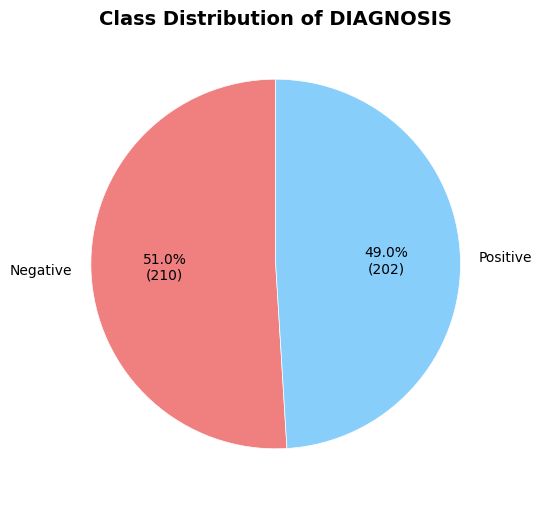

In [74]:
class_counts = y.value_counts()
labels = ['Negative', 'Positive']

def autopct_format(values):
    def inner_autopct(pct):
        total = sum(values)
        count = int(round(pct * total / 100.0))
        return f'{pct:.1f}%\n({count:d})'
    return inner_autopct

plt.figure(figsize=(6, 6))
plt.pie(class_counts, labels=labels, autopct=autopct_format(class_counts), startangle=90, 
        colors=['lightcoral', 'lightskyblue'], wedgeprops={'linewidth': 0.5, 'edgecolor': 'white'})

plt.title('Class Distribution of DIAGNOSIS', fontsize=14, fontweight='bold')

plt.show()

In [75]:
X_train_val, X_test_val, y_train_val, y_test_val = train_test_split(X_train, 
                                                                    y_train, 
                                                                    test_size=0.2,
                                                                    random_state=42,
                                                                   stratify = y_train)

In [76]:
def show_study_summary(study: optuna.study.Study) -> None:
    print("\033[1mBest Hyperparameters")
    pprint(study.best_params)
    print()

    print("\033[1mAccuracy for the Best Hyperparameters")
    print(study.best_value)

    optimization_history_plot = optuna.visualization.plot_optimization_history(study)
    param_importances_plot = optuna.visualization.plot_param_importances(study)


    optimization_history_plot.update_layout({"height": 600})
    param_importances_plot.update_layout({"height": 600})


    optimization_history_plot.show()
    param_importances_plot.show()


## Logistic Regression

In [77]:
def logreg_objective(trial: optuna.study.Study) -> float:
    PARAMS = {
        "tol": trial.suggest_float("tol", 1e-6, 1e-2, log=True),
        "C": trial.suggest_float("C", 0.1, 1)
    }

    LOGREG = LogisticRegression(**PARAMS, max_iter=2000, random_state=42)

    LOGREG.fit(X_train_val, y_train_val)

    THRESHOLD = trial.suggest_float('threshold', 0.1, 1)

    YHAT = [1 if proba[1] > THRESHOLD else 0 for proba in LOGREG.predict_proba(X_test_val)]

    F1_SCORE_ = f1_score(y_test_val, YHAT)

    return F1_SCORE_

SEED = 42  
SAMPLER = optuna.samplers.TPESampler(seed=SEED)


LOGREG_STUDY = optuna.create_study(direction="maximize", study_name="logreg_tuning", sampler=SAMPLER)

LOGREG_STUDY.optimize(logreg_objective, n_trials=200, n_jobs=-1, show_progress_bar=True)

[I 2024-11-12 23:49:34,372] A new study created in memory with name: logreg_tuning


  0%|          | 0/200 [00:00<?, ?it/s]

[I 2024-11-12 23:49:34,402] Trial 0 finished with value: 0.8771929824561403 and parameters: {'tol': 0.00026672823535932023, 'C': 0.15181084287769975, 'threshold': 0.6681133076344763}. Best is trial 0 with value: 0.8771929824561403.
[I 2024-11-12 23:49:34,415] Trial 1 finished with value: 0.9333333333333333 and parameters: {'tol': 0.001521507324581147, 'C': 0.6811493405937196, 'threshold': 0.42823510488223826}. Best is trial 1 with value: 0.9333333333333333.
[I 2024-11-12 23:49:34,465] Trial 3 finished with value: 0.9333333333333333 and parameters: {'tol': 0.004720869306127513, 'C': 0.7104535187673615, 'threshold': 0.38992075898162737}. Best is trial 1 with value: 0.9333333333333333.
[I 2024-11-12 23:49:34,477] Trial 2 finished with value: 0.9152542372881356 and parameters: {'tol': 1.0377814416067941e-05, 'C': 0.33588868476173983, 'threshold': 0.5884973542579529}. Best is trial 1 with value: 0.9333333333333333.
[I 2024-11-12 23:49:34,482] Trial 8 finished with value: 0.8823529411764706 

In [78]:
show_study_summary(LOGREG_STUDY)

Best Hyperparameters
{'C': 0.7896806917636754,
 'threshold': 0.2896020384143362,
 'tol': 0.009977026606959545}

Accuracy for the Best Hyperparameters
0.9523809523809523


## Support Vector Machine

In [79]:
def SVC_objective(trial: optuna.study.Study) -> float:
    PARAMS = {
        "C": trial.suggest_float("C", 0.1, 10, log=True),
        "kernel": trial.suggest_categorical("kernel", ["linear", "poly", "rbf", "sigmoid"])
    }

    SVC_MODEL = SVC(**PARAMS, probability=True, random_state=42)

    SVC_MODEL.fit(X_train_val, y_train_val)

    YHAT = SVC_MODEL.predict(X_test_val)

    F1_SCORE_ = f1_score(y_test_val, YHAT)

    return F1_SCORE_

SEED = 42  
SAMPLER = optuna.samplers.TPESampler(seed=SEED)

SVM_SVC_STUDY = optuna.create_study(direction="maximize", study_name="SVM_tuning", sampler=SAMPLER)

SVM_SVC_STUDY.optimize(SVC_objective, n_trials=200, n_jobs=-1, show_progress_bar=True)

[I 2024-11-12 23:49:39,461] A new study created in memory with name: SVM_tuning


  0%|          | 0/200 [00:00<?, ?it/s]

[I 2024-11-12 23:49:39,485] Trial 1 finished with value: 0.9333333333333333 and parameters: {'C': 1.629876823692498, 'kernel': 'linear'}. Best is trial 1 with value: 0.9333333333333333.
[I 2024-11-12 23:49:39,496] Trial 3 finished with value: 0.8518518518518519 and parameters: {'C': 0.102791363749472, 'kernel': 'sigmoid'}. Best is trial 1 with value: 0.9333333333333333.
[I 2024-11-12 23:49:39,509] Trial 2 finished with value: 0.9152542372881356 and parameters: {'C': 4.0618134893936455, 'kernel': 'poly'}. Best is trial 1 with value: 0.9333333333333333.
[I 2024-11-12 23:49:39,515] Trial 0 finished with value: 0.8076923076923077 and parameters: {'C': 0.6420482692506007, 'kernel': 'poly'}. Best is trial 1 with value: 0.9333333333333333.
[I 2024-11-12 23:49:39,521] Trial 4 finished with value: 0.8076923076923077 and parameters: {'C': 0.6381519599500005, 'kernel': 'poly'}. Best is trial 1 with value: 0.9333333333333333.
[I 2024-11-12 23:49:39,553] Trial 6 finished with value: 0.9333333333333

In [80]:
show_study_summary(SVM_SVC_STUDY)

Best Hyperparameters
{'C': 1.629876823692498, 'kernel': 'linear'}

Accuracy for the Best Hyperparameters
0.9333333333333333


## XGBoost


In [81]:
def XGB_objective(trial: optuna.study.Study) -> float:

    PARAMS = {
        "objective": "binary:logistic",
        "booster": "gbtree",
        "reg_alpha": trial.suggest_float("reg_alpha", 0.1, 0.9),
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000, step=50),
        "max_depth": trial.suggest_int("max_depth", 3, 15),
        "learning_rate": trial.suggest_float("learning_rate", 0.0001, 0.1, log=True),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0)
    }

    XGB_model = xgb.XGBClassifier(**PARAMS, random_state=42)

    XGB_model.fit(X_train_val, y_train_val)

    YHAT = XGB_model.predict(X_test_val)

    F1_SCORE_ = f1_score(y_test_val, YHAT)

    return F1_SCORE_

SEED = 42  
SAMPLER = optuna.samplers.TPESampler(seed=SEED)

XGB_STUDY = optuna.create_study(direction="maximize", study_name="XGB_tuning", sampler=SAMPLER)

XGB_STUDY.optimize(XGB_objective, n_trials=200, n_jobs=-1, show_progress_bar=True)

[I 2024-11-12 23:49:42,137] A new study created in memory with name: XGB_tuning


  0%|          | 0/200 [00:00<?, ?it/s]

[I 2024-11-12 23:49:42,378] Trial 5 finished with value: 0.9508196721311475 and parameters: {'reg_alpha': 0.7252824332473127, 'n_estimators': 200, 'max_depth': 11, 'learning_rate': 0.0004427252001674663, 'subsample': 0.5772674526089946, 'colsample_bytree': 0.5685494954965147}. Best is trial 5 with value: 0.9508196721311475.
[I 2024-11-12 23:49:42,420] Trial 2 finished with value: 0.9508196721311475 and parameters: {'reg_alpha': 0.7128976998653762, 'n_estimators': 200, 'max_depth': 7, 'learning_rate': 0.013261636061115864, 'subsample': 0.8681387291805027, 'colsample_bytree': 0.9962468851274348}. Best is trial 5 with value: 0.9508196721311475.
[I 2024-11-12 23:49:42,630] Trial 1 finished with value: 0.9152542372881356 and parameters: {'reg_alpha': 0.38736455707434425, 'n_estimators': 450, 'max_depth': 12, 'learning_rate': 0.0014355376645704776, 'subsample': 0.5576629303476259, 'colsample_bytree': 0.9875281525450375}. Best is trial 5 with value: 0.9508196721311475.
[I 2024-11-12 23:49:42,

In [82]:
show_study_summary(XGB_STUDY)

Best Hyperparameters
{'colsample_bytree': 0.5299782011056966,
 'learning_rate': 0.0006288316717283618,
 'max_depth': 7,
 'n_estimators': 100,
 'reg_alpha': 0.6270970040087323,
 'subsample': 0.9032685702942773}

Accuracy for the Best Hyperparameters
0.967741935483871


## LGBM

In [83]:
def lightgbm_objective(trial: optuna.study.Study) -> float:

    PARAMS = {
        "data_sample_strategy": "goss",
        "verbosity": -1,
        "boosting_type": trial.suggest_categorical("boosting_type", ["gbdt", "dart"]),
        "num_leaves": trial.suggest_int('num_leaves', 10, 200, step=10),
        "n_estimators": trial.suggest_int("n_estimators", 100, 500, step=50),
        "max_depth": trial.suggest_categorical("max_depth", [-1, 3, 4, 5]),
        "learning_rate": trial.suggest_float("learning_rate", 0.0001, 0.1, log=True),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.1, 0.9),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100)
    }
    
    LGMB_MODEL = lgb.LGBMClassifier(**PARAMS, random_state=42)
    
    LGMB_MODEL.fit(X_train_val, y_train_val) 
    
    YHAT = LGMB_MODEL.predict(X_test_val)
    
    F1_SCORE_ = f1_score(y_test_val, YHAT)
    
    return F1_SCORE_

SEED = 42  
SAMPLER = optuna.samplers.TPESampler(seed=SEED)

LGBM_STUDY = optuna.create_study(direction="maximize", study_name="lgbm_tuning", sampler=SAMPLER)

LGBM_STUDY.optimize(lightgbm_objective, n_trials=200, n_jobs=-1, show_progress_bar=True)

[I 2024-11-12 23:49:59,543] A new study created in memory with name: lgbm_tuning


  0%|          | 0/200 [00:00<?, ?it/s]

[I 2024-11-12 23:49:59,656] Trial 2 finished with value: 0.8363636363636363 and parameters: {'boosting_type': 'dart', 'num_leaves': 30, 'n_estimators': 100, 'max_depth': 4, 'learning_rate': 0.010616144390695307, 'reg_alpha': 0.49915956755491375, 'subsample': 0.8068409728197335, 'colsample_bytree': 0.7328476264515531, 'min_child_samples': 47}. Best is trial 2 with value: 0.8363636363636363.
[I 2024-11-12 23:49:59,674] Trial 5 finished with value: 0.9152542372881356 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 90, 'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.04317164368389186, 'reg_alpha': 0.2547699229978375, 'subsample': 0.8107681491092527, 'colsample_bytree': 0.9016657555858021, 'min_child_samples': 45}. Best is trial 5 with value: 0.9152542372881356.
[I 2024-11-12 23:49:59,707] Trial 7 finished with value: 0.17857142857142858 and parameters: {'boosting_type': 'dart', 'num_leaves': 30, 'n_estimators': 250, 'max_depth': 5, 'learning_rate': 0.016535215603627782, 're

In [84]:
show_study_summary(LGBM_STUDY)

Best Hyperparameters
{'boosting_type': 'gbdt',
 'colsample_bytree': 0.5282274845831836,
 'learning_rate': 0.00011598155359899454,
 'max_depth': -1,
 'min_child_samples': 5,
 'n_estimators': 350,
 'num_leaves': 60,
 'reg_alpha': 0.8953376860947742,
 'subsample': 0.5105826618867267}

Accuracy for the Best Hyperparameters
0.967741935483871


## TabNet

In [85]:
def tabnet_objective(trial: optuna.study.Study) -> float:

    PARAMS = {
    "n_d": trial.suggest_int('n_d', 8, 64),  
    "n_a": trial.suggest_int('n_a', 8, 64), 
    "n_steps": trial.suggest_int('n_steps', 3, 10),  
    "gamma": trial.suggest_float('gamma', 1.0, 2.0),  
    "lambda_sparse": trial.suggest_float('lambda_sparse', 1e-5, 1e-3, log=True), 
    "n_independent": trial.suggest_int('n_independent', 1, 5),  
    "n_shared": trial.suggest_int('n_shared', 1, 5)  
    }

    TAB_MODEL = TabNetClassifier(**PARAMS)

    TAB_MODEL.fit(X_train_val, y_train_val,
        max_epochs=100,
        patience=15,  
        batch_size=528,
        virtual_batch_size=64)

    YHAT = TAB_MODEL.predict(X_test_val)

    F1_SCORE_ = f1_score(y_test_val, YHAT)

    return F1_SCORE_

SEED = 42  
SAMPLER = optuna.samplers.TPESampler(seed=SEED)

TABNET_STUDY = optuna.create_study(direction="maximize", study_name="tabnet_tuning", sampler=SAMPLER)

TABNET_STUDY.optimize(tabnet_objective, n_trials=200, n_jobs=-1, show_progress_bar=True)


[I 2024-11-12 23:50:15,955] A new study created in memory with name: tabnet_tuning


  0%|          | 0/200 [00:00<?, ?it/s]

epoch 0  | loss: 0.0     |  0:00:00s
epoch 1  | loss: 0.0     |  0:00:00s
epoch 2  | loss: 0.0     |  0:00:00s
epoch 3  | loss: 0.0     |  0:00:00s
epoch 4  | loss: 0.0     |  0:00:00s
epoch 5  | loss: 0.0     |  0:00:00s
epoch 6  | loss: 0.0     |  0:00:00s
epoch 7  | loss: 0.0     |  0:00:00s
epoch 8  | loss: 0.0     |  0:00:00s
epoch 9  | loss: 0.0     |  0:00:00s
epoch 10 | loss: 0.0     |  0:00:00s
epoch 11 | loss: 0.0     |  0:00:00s
epoch 12 | loss: 0.0     |  0:00:00s
epoch 13 | loss: 0.0     |  0:00:00s
epoch 0  | loss: 0.0     |  0:00:00s
epoch 1  | loss: 0.0     |  0:00:00s
epoch 2  | loss: 0.0     |  0:00:00s
epoch 14 | loss: 0.0     |  0:00:00s
epoch 15 | loss: 0.0     |  0:00:00s
epoch 3  | loss: 0.0     |  0:00:00s
epoch 16 | loss: 0.0     |  0:00:00s
epoch 4  | loss: 0.0     |  0:00:00s
epoch 17 | loss: 0.0     |  0:00:00s
epoch 5  | loss: 0.0     |  0:00:00s
epoch 18 | loss: 0.0     |  0:00:00s
epoch 6  | loss: 0.0     |  0:00:00s
epoch 19 | loss: 0.0     |  0:00:00s
e

In [86]:
show_study_summary(TABNET_STUDY)

Best Hyperparameters
{'gamma': 1.574806951745601,
 'lambda_sparse': 3.7266374668980965e-05,
 'n_a': 19,
 'n_d': 61,
 'n_independent': 1,
 'n_shared': 2,
 'n_steps': 4}

Accuracy for the Best Hyperparameters
0.7466666666666667


In [87]:
from typing import Union, Tuple
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

def test_model(
        models: list,
        params: dict,
        X_train: Union[np.ndarray, pd.DataFrame],
        y_train: Union[np.ndarray, pd.Series],
        X_test: Union[np.ndarray, pd.DataFrame],
        y_test: Union[np.ndarray, pd.Series]
    ) -> Tuple[dict, pd.DataFrame]:

    model_testing_scores = pd.DataFrame()
    models_container = {}

    model_testing_scores["Model"] = []
    model_testing_scores["Accuracy"] = []
    model_testing_scores["Precision"] = []
    model_testing_scores["Recall"] = []
    model_testing_scores["F1-Score"] = []
    model_testing_scores["Specificity"] = []
    model_testing_scores["AUC-ROC"] = []

    for model in tqdm(models):
        MODEL_NAME = model().__class__.__name__
        MODEL_KEY = MODEL_NAME + "_R" if (MODEL_NAME + "_R") in params else MODEL_NAME

        # Check if model is Logistic Regression with a threshold
        if MODEL_KEY == "LogisticRegression_R" or MODEL_KEY == "LogisticRegression":
            test_model = model(tol=params[MODEL_KEY]["tol"],
                               C=params[MODEL_KEY]["C"],
                               max_iter=2000)
            test_model.fit(X_train, y_train)

            # Apply custom threshold
            test_pred = [1 if proba[1] > params[MODEL_KEY]["threshold"] else 0 for proba in
                         test_model.predict_proba(X_test)]

        # Check if model is TabNetClassifier
        elif MODEL_KEY == "TabNetClassifier":
            # Convert to numpy arrays if they are DataFrames for TabNet compatibility
            X_train_input = X_train.values if isinstance(X_train, pd.DataFrame) else X_train
            X_test_input = X_test.values if isinstance(X_test, pd.DataFrame) else X_test

            test_model = model(**params[MODEL_KEY])
            test_model.fit(X_train_input, y_train)  # Use numpy array
            test_pred = test_model.predict(X_test_input)  # Use numpy array

        # For all other models
        else:
            test_model = model(**params[MODEL_KEY])
            test_model.fit(X_train, y_train)
            test_pred = test_model.predict(X_test)

        # Calculate metrics
        TN, FP, _, _ = confusion_matrix(y_test, test_pred).ravel()
        TESTING_SPECIFICITY = TN / (TN + FP)

        # Append results to the DataFrame
        model_testing_scores = model_testing_scores._append({
            "Model": MODEL_KEY,
            "Accuracy": accuracy_score(y_test, test_pred),
            "Precision": precision_score(y_test, test_pred),
            "Recall": recall_score(y_test, test_pred),
            "F1-Score": f1_score(y_test, test_pred),
            "Specificity": TESTING_SPECIFICITY,
            "AUC-ROC": roc_auc_score(y_test, test_pred)
        }, ignore_index=True)

        # Store the trained model in the container
        models_container[MODEL_KEY] = test_model

    return models_container, model_testing_scores


In [88]:
LIST_OF_MODELS = [LogisticRegression, SVC, xgb.XGBClassifier, lgb.LGBMClassifier, TabNetClassifier]

MODELS_PARAMETERS = {"LogisticRegression":{'C': 0.2365747466226469,
                    'threshold': 0.29343601050837254,
                    'tol': 2.28895425023624e-06
                    },
                     
                    "SVC":{'C': 0.4018032075748924, 'kernel': 'linear', 'probability': True},
                     
                    "XGBClassifier":{'learning_rate': 0.013063286229945145,
                                    'max_depth': 11,
                                    'n_estimators': 300,
                                    'reg_alpha': 0.8231888739256502
                                    },
                     
                     "LGBMClassifier": {"data_sample_strategy": "goss",
                                        "verbosity": -1, 
                                        'boosting_type': 'gbdt',
                                        'learning_rate': 0.07123575107452054,
                                        'max_depth': 5,
                                        'n_estimators': 200,
                                        'num_leaves': 100,
                                        'reg_alpha': 0.3771805609488842

                                        },
                    "TabNetClassifier": {'gamma': 1.4803802329168332,
                                        'lambda_sparse': 7.110709471474281e-05,
                                        'n_a': 17,
                                        'n_d': 13,
                                        'n_independent': 3,
                                        'n_shared': 4,
                                        'n_steps': 7
                                        }
                    }


MODEL_CONTAINER, TESTING_SCORES = test_model(LIST_OF_MODELS, MODELS_PARAMETERS, X_train, y_train, X_test, y_test)

 60%|██████    | 3/5 [00:00<00:00, 22.38it/s]

epoch 0  | loss: 0.0     |  0:00:00s
epoch 1  | loss: 0.0     |  0:00:00s
epoch 2  | loss: 0.0     |  0:00:00s
epoch 3  | loss: 0.0     |  0:00:00s
epoch 4  | loss: 0.0     |  0:00:00s
epoch 5  | loss: 0.0     |  0:00:00s
epoch 6  | loss: 0.0     |  0:00:00s
epoch 7  | loss: 0.0     |  0:00:00s
epoch 8  | loss: 0.0     |  0:00:00s
epoch 9  | loss: 0.0     |  0:00:00s
epoch 10 | loss: 0.0     |  0:00:00s
epoch 11 | loss: 0.0     |  0:00:00s
epoch 12 | loss: 0.0     |  0:00:00s
epoch 13 | loss: 0.0     |  0:00:00s
epoch 14 | loss: 0.0     |  0:00:00s
epoch 15 | loss: 0.0     |  0:00:00s
epoch 16 | loss: 0.0     |  0:00:00s
epoch 17 | loss: 0.0     |  0:00:00s
epoch 18 | loss: 0.0     |  0:00:00s
epoch 19 | loss: 0.0     |  0:00:00s
epoch 20 | loss: 0.0     |  0:00:00s
epoch 21 | loss: 0.0     |  0:00:00s
epoch 22 | loss: 0.0     |  0:00:00s
epoch 23 | loss: 0.0     |  0:00:00s
epoch 24 | loss: 0.0     |  0:00:00s
epoch 25 | loss: 0.0     |  0:00:00s
epoch 26 | loss: 0.0     |  0:00:00s
e

100%|██████████| 5/5 [00:00<00:00, 11.93it/s]


In [89]:
def display_confusion_matrices(model_container, X_test, y_test):
    for name, model in model_container.items():
        # Make predictions
        y_pred = model.predict(X_test)
        
        # Calculate confusion matrix
        cm = confusion_matrix(y_test, y_pred)
        
        # Plot confusion matrix
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
        plt.title(f"Confusion Matrix for {name}")
        plt.xlabel("Predicted Label")
        plt.ylabel("True Label")
        plt.show()

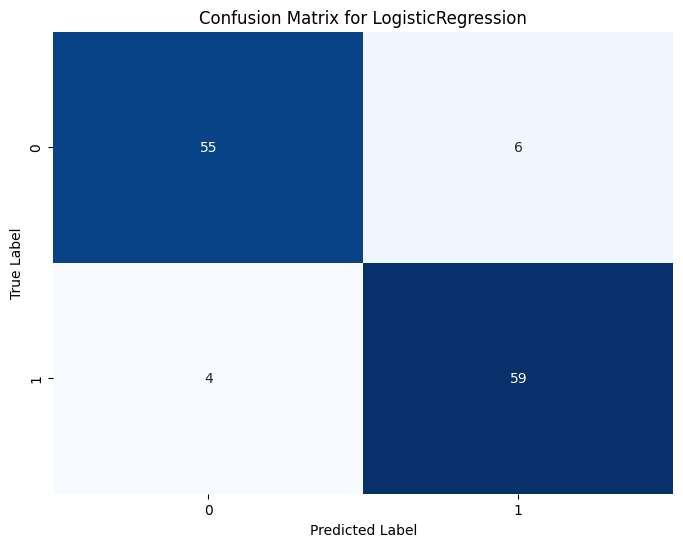

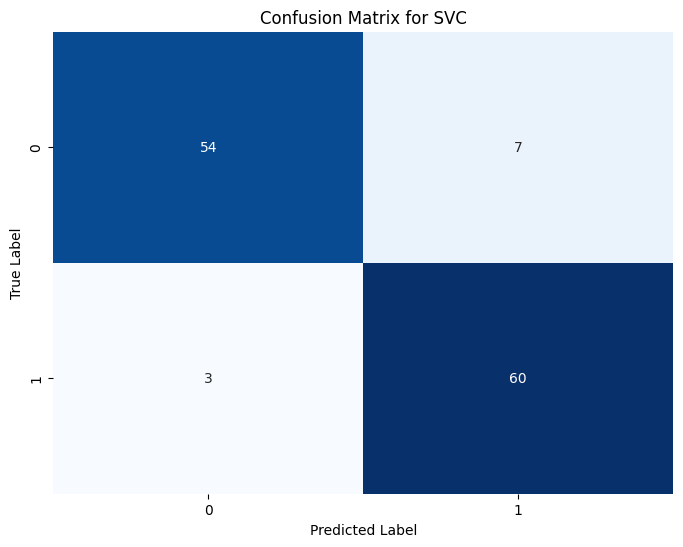

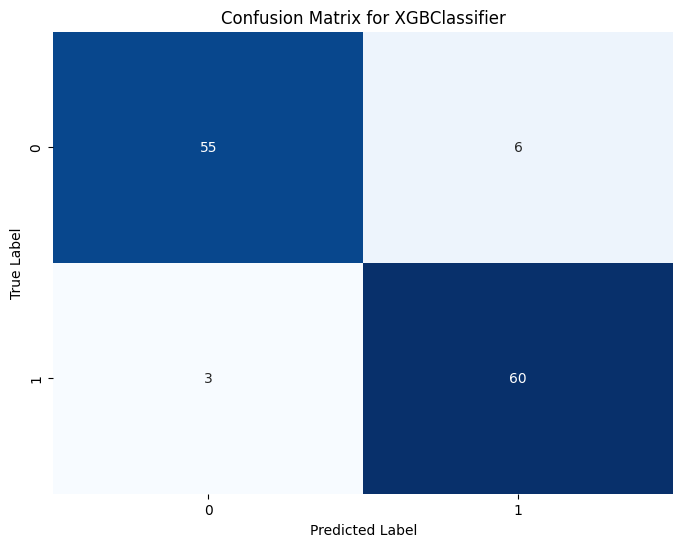

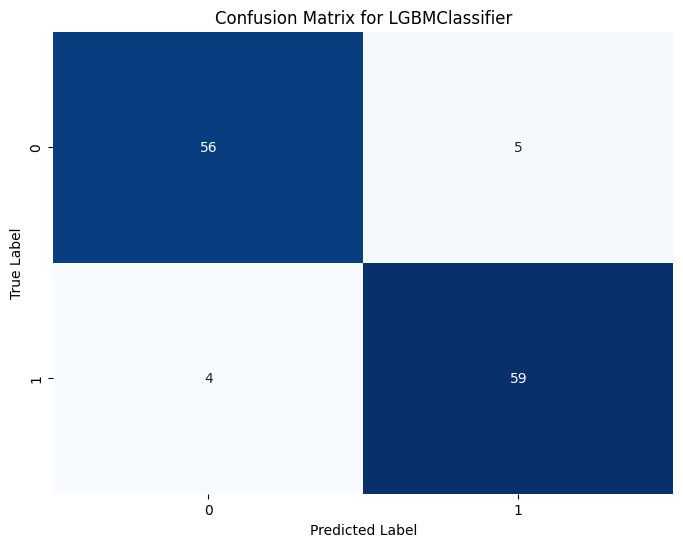

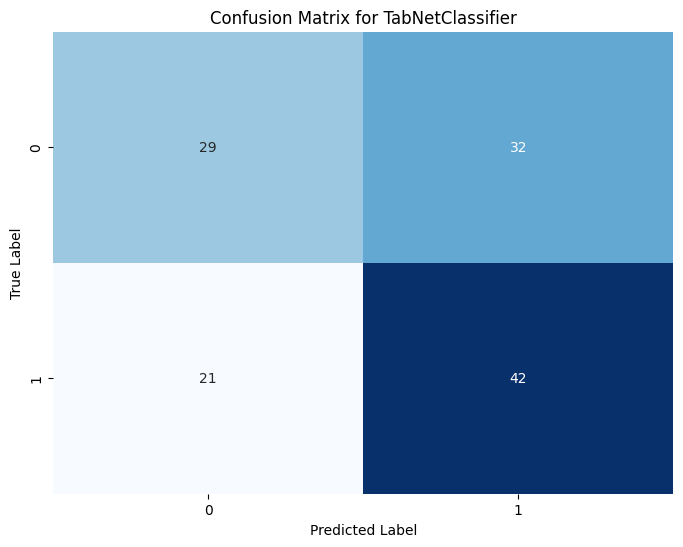

In [90]:
display_confusion_matrices(MODEL_CONTAINER, X_test, y_test)

In [91]:
TESTING_SCORES

Model  Accuracy  Precision    Recall  F1-Score  Specificity  \
0  LogisticRegression  0.919355   0.873239  0.984127  0.925373     0.852459   
1                 SVC  0.919355   0.895522  0.952381  0.923077     0.885246   
2       XGBClassifier  0.927419   0.909091  0.952381  0.930233     0.901639   
3      LGBMClassifier  0.927419   0.921875  0.936508  0.929134     0.918033   
4    TabNetClassifier  0.572581   0.567568  0.666667  0.613139     0.475410   

    AUC-ROC  
0  0.918293  
1  0.918813  
2  0.927010  
3  0.927270  
4  0.571038

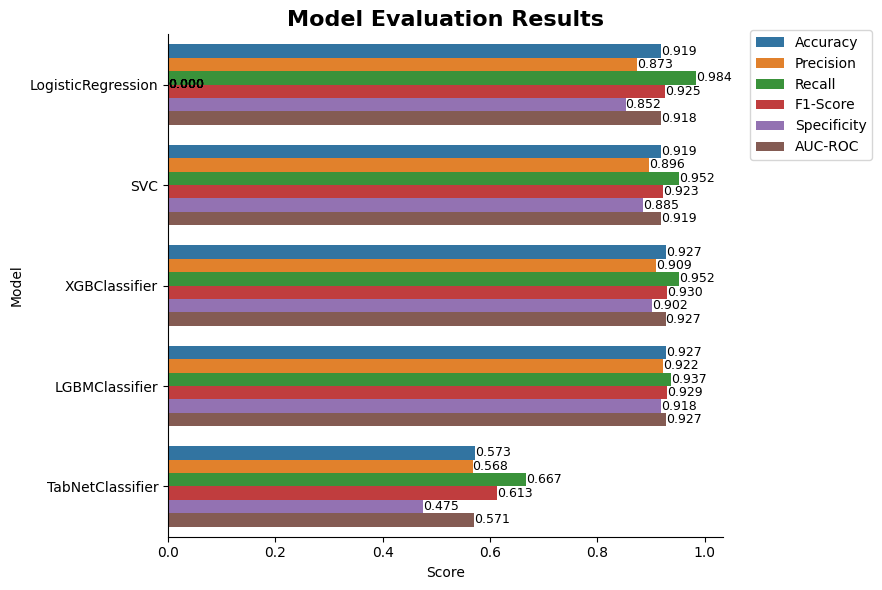

In [92]:
# Prepare data for plotting
plot_df = pd.melt(TESTING_SCORES, id_vars=["Model"])
plot_df.rename({"variable": "Metric", "value": "Score"}, axis=1, inplace=True)

PLOT = sns.catplot(
    x="Score", 
    y="Model", 
    hue="Metric", 
    data=plot_df, 
    kind="bar", 
    orient="h",
    height=6, 
    aspect=1.5, 
    legend_out=False,
    palette="tab10"  
)

# Access the axes of the plot
ax = PLOT.axes[0, 0]

# Annotate the bars with their corresponding scores
for p in ax.patches:
    ax.annotate(f"{p.get_width():.3f}", 
                (p.get_x() + p.get_width(), p.get_y() + p.get_height() / 2),
                ha="left", va="center", fontsize=9)

# Set plot title and legend
plt.title("Model Evaluation Results", fontsize=16, fontweight='bold')
plt.legend(loc=(1.05, 0.75))
plt.tight_layout()

# Display the plot
plt.show()


In [93]:
def plot_feature_importances(model, X_columns, title, top_n=20):

    # Extract and sort feature importances
    results = {column: value for value, column in zip(model.feature_importances_, X_columns)}
    sorted_results = sorted(results.items(), key=lambda x: x[1], reverse=True)[:top_n]  # Top N features

    # Separate names and values for the top features
    feature_names, importances = zip(*sorted_results)

    plt.figure(figsize=(14, 8))  
    plt.barh(range(len(importances)), importances, align='center', color="lightblue")
    plt.yticks(range(len(feature_names)), [name[:15] + '...' if len(name) > 15 else name for name in feature_names], fontsize=9)

    # Set titles and labels
    plt.title(f"{title}: Top {top_n} Feature Importance", fontsize=14, fontweight='bold')
    plt.xlabel("Feature importance", fontsize=12)
    plt.ylabel("Feature", fontsize=12)
    plt.ylim(-1, top_n)
    plt.gca().invert_yaxis()  
    plt.show()



In [94]:
TRAINED_XGB = MODEL_CONTAINER["XGBClassifier"]
TRAINED_LGBM = MODEL_CONTAINER["LGBMClassifier"]
TRAINED_SVM = MODEL_CONTAINER["SVC"]
TRAINED_LOGREG = MODEL_CONTAINER["LogisticRegression"]
TRAINED_TABNET = MODEL_CONTAINER["TabNetClassifier"]

## TABNET FEATURE IMPORTANCE

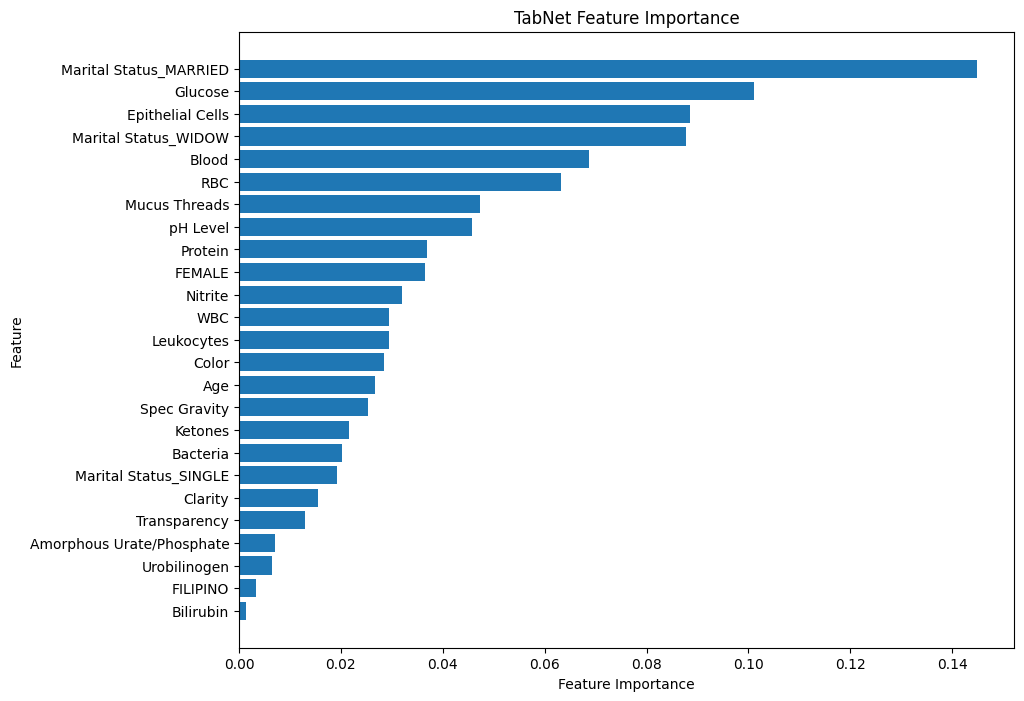

In [95]:
feature_importances = TRAINED_TABNET.feature_importances_ 
feature_names = X.columns 
sorted_indices = feature_importances.argsort()[::-1]
sorted_feature_importances = feature_importances[sorted_indices]
sorted_feature_names = feature_names[sorted_indices]

plt.figure(figsize=(10, 8))
plt.barh(sorted_feature_names, sorted_feature_importances)
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title("TabNet Feature Importance")
plt.gca().invert_yaxis()
plt.show()

## XGB SHAP

In [96]:
XGB_EXPLAINER = shap.TreeExplainer(TRAINED_XGB, X_test)

XGB_SHAP_VALUES = XGB_EXPLAINER.shap_values(X_test, check_additivity=False)

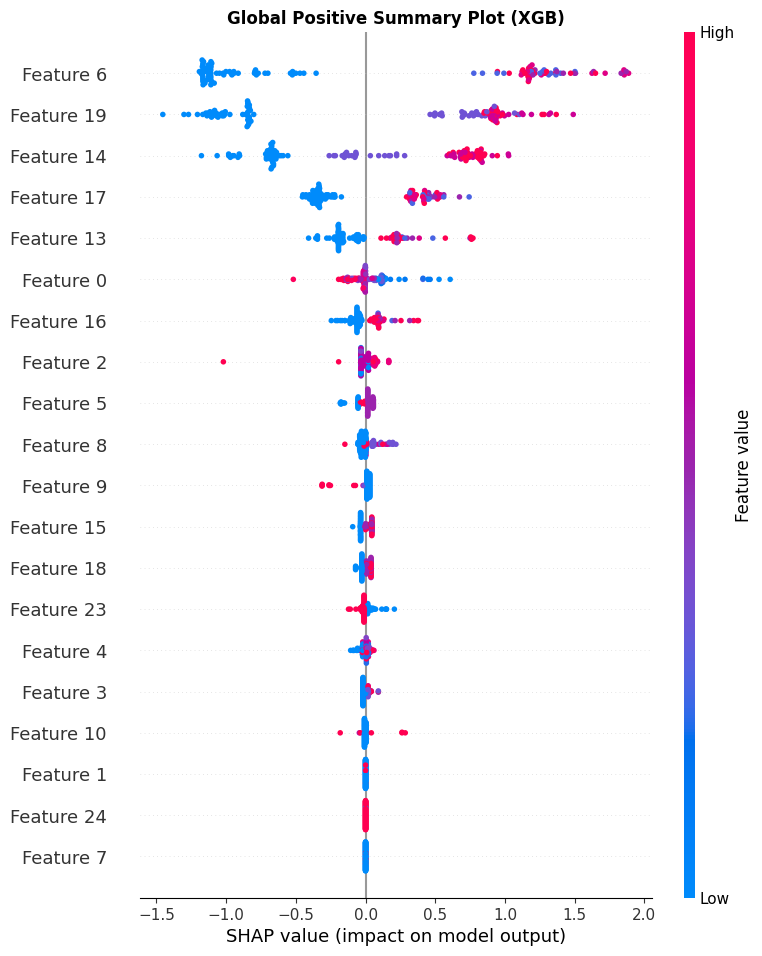

In [97]:
# SHAP Global Positive Summary Plot
shap.summary_plot(XGB_SHAP_VALUES, X_test, show=False)
plt.title("Global Positive Summary Plot (XGB)", fontdict={"fontweight":"bold"})
plt.show()

## LGB SHAP

In [98]:
LGBM_EXPLAINER = shap.TreeExplainer(TRAINED_LGBM, X_test)

LGBM_SHAP_VALUES = LGBM_EXPLAINER.shap_values(X_test, check_additivity=False)

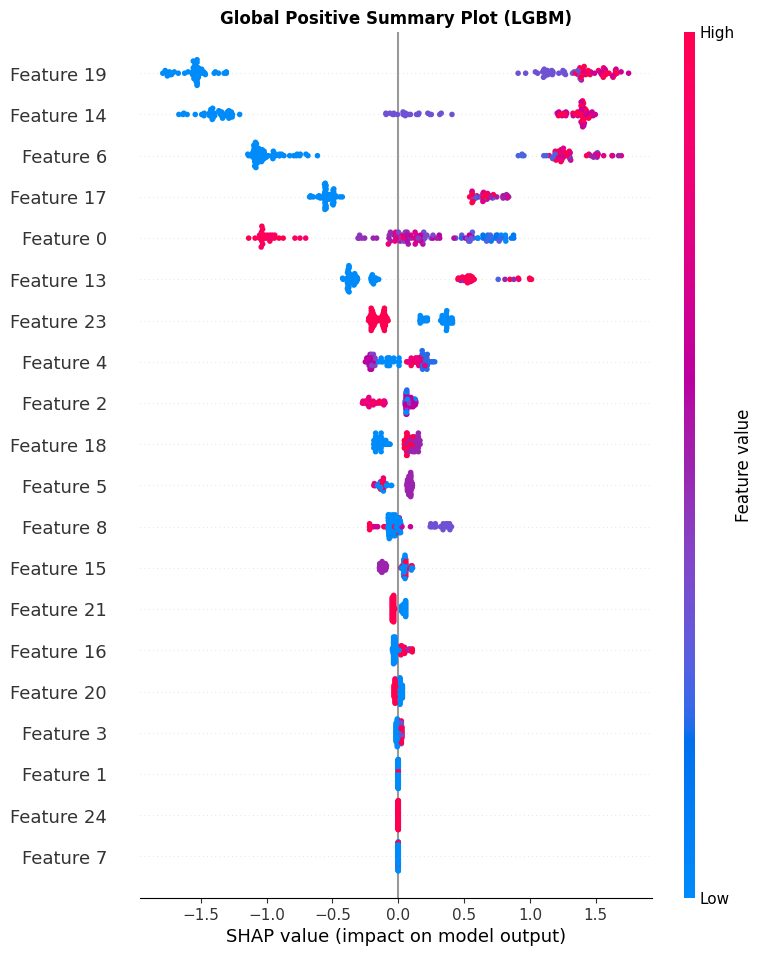

In [99]:
# SHAP Global Positive Summary Plot
shap.summary_plot(LGBM_SHAP_VALUES, X_test, show=False)
plt.title("Global Positive Summary Plot (LGBM)", fontdict={"fontweight":"bold"})
plt.show()

## LOGREG SHAP

In [100]:
LOGREG_EXPLAINER = shap.LinearExplainer(TRAINED_LOGREG, X_test)

LOGREG_SHAP_VALUES = LOGREG_EXPLAINER.shap_values(X_test)

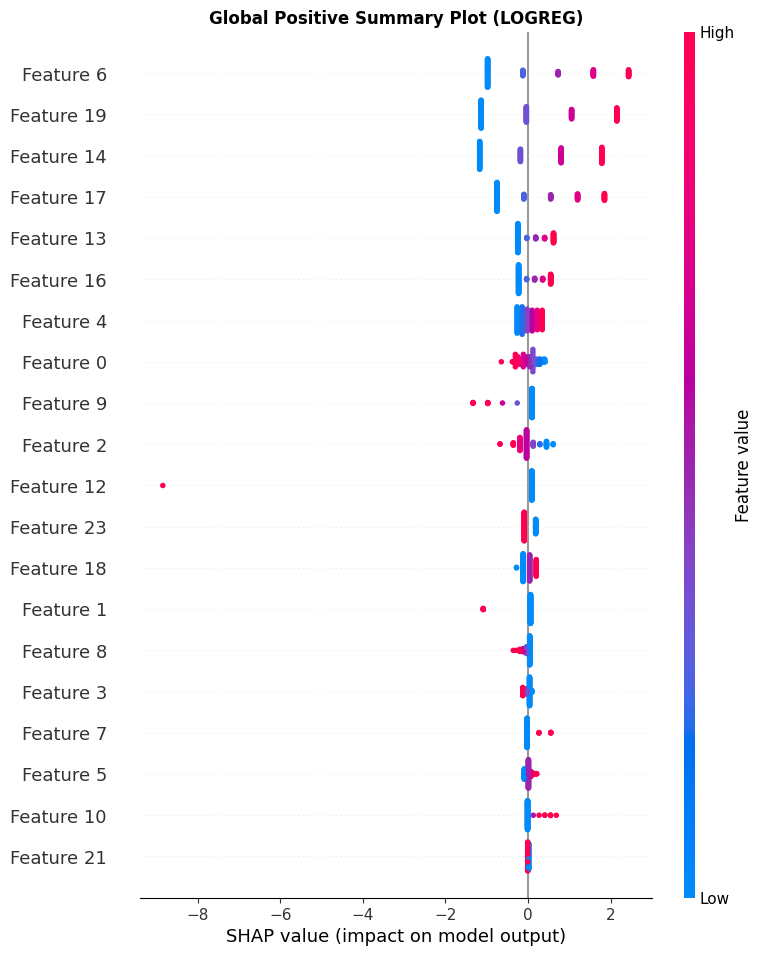

In [101]:
# SHAP Global Positive Summary Plot
shap.summary_plot(LOGREG_SHAP_VALUES, X_test, show=False)
plt.title("Global Positive Summary Plot (LOGREG)", fontdict={"fontweight":"bold"})
plt.show()

## SVM SHAP

In [102]:
SVM_EXPLAINER = shap.LinearExplainer(TRAINED_SVM, X_test)

SVM_SHAP_VALUES = SVM_EXPLAINER.shap_values(X_test)

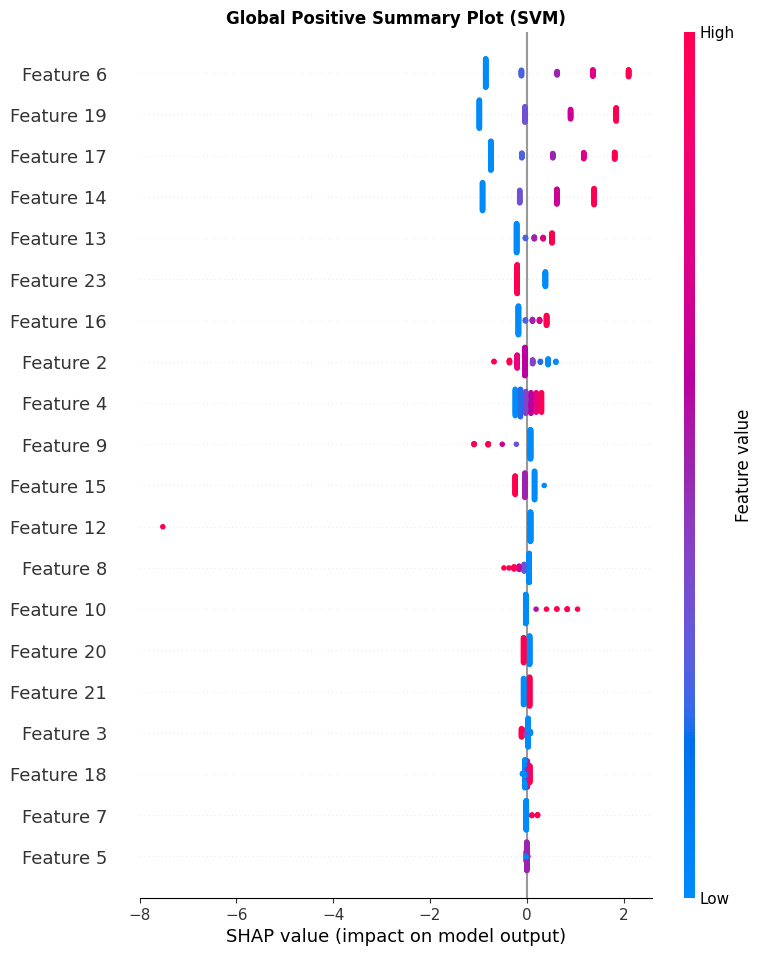

In [103]:
# SHAP Global Positive Summary Plot
shap.summary_plot(SVM_SHAP_VALUES, X_test, show=False)
plt.title("Global Positive Summary Plot (SVM)", fontdict={"fontweight":"bold"})
plt.show()

In [104]:
import pandas as pd

def print_top_shap_features(shap_values, feature_names, model_name="Model", top_n=10):
 
    shap_values_df = pd.DataFrame(shap_values, columns=feature_names)

    shap_values_sum = shap_values_df.abs().mean(axis=0)

    top_features = shap_values_sum.sort_values(ascending=False).head(top_n)

    print(f"\nTop {top_n} Features for {model_name} based on SHAP values:")
    print(top_features.to_frame(name='Mean Absolute SHAP Value'))

    return np.array(top_features.index)


In [105]:
top_features_svm = print_top_shap_features(SVM_SHAP_VALUES, feature_names=X.columns, model_name="SVC", top_n=10)
top_features_svm


Top 10 Features for SVC based on SHAP values:
                           Mean Absolute SHAP Value
Leukocytes                                 0.988253
Amorphous Urate/Phosphate                  0.923385
WBC                                        0.861709
Bacteria                                   0.824200
Blood                                      0.277084
FEMALE                                     0.261149
RBC                                        0.223292
Color                                      0.167999
Spec Gravity                               0.161818
Glucose                                    0.142118


array(['Leukocytes', 'Amorphous Urate/Phosphate', 'WBC', 'Bacteria',
       'Blood', 'FEMALE', 'RBC', 'Color', 'Spec Gravity', 'Glucose'],
      dtype=object)

In [106]:
top_features_lgbm = print_top_shap_features(LGBM_SHAP_VALUES, feature_names=X.columns, model_name="LGBMClassifier", top_n=10)
top_features_lgbm


Top 10 Features for LGBMClassifier based on SHAP values:
                           Mean Absolute SHAP Value
Amorphous Urate/Phosphate                  1.449091
Bacteria                                   1.158054
Leukocytes                                 1.130503
WBC                                        0.596030
Age                                        0.483333
Blood                                      0.416551
FEMALE                                     0.203647
Spec Gravity                               0.160913
Color                                      0.117772
Mucus Threads                              0.113434


array(['Amorphous Urate/Phosphate', 'Bacteria', 'Leukocytes', 'WBC',
       'Age', 'Blood', 'FEMALE', 'Spec Gravity', 'Color', 'Mucus Threads'],
      dtype=object)

In [107]:
top_features_xgb = print_top_shap_features(XGB_SHAP_VALUES, feature_names=X.columns, model_name="XGBClassifier", top_n=10)
top_features_xgb


Top 10 Features for XGBClassifier based on SHAP values:
                           Mean Absolute SHAP Value
Leukocytes                                 1.147252
Amorphous Urate/Phosphate                  0.932493
Bacteria                                   0.640628
WBC                                        0.374369
Blood                                      0.213086
Age                                        0.088693
RBC                                        0.088226
Color                                      0.046087
pH Level                                   0.045524
Protein                                    0.037799


array(['Leukocytes', 'Amorphous Urate/Phosphate', 'Bacteria', 'WBC',
       'Blood', 'Age', 'RBC', 'Color', 'pH Level', 'Protein'],
      dtype=object)

In [108]:
top_features_logreg = print_top_shap_features(LOGREG_SHAP_VALUES, feature_names=X.columns, model_name="LogisitcRegression", top_n=10)


Top 10 Features for LogisitcRegression based on SHAP values:
                           Mean Absolute SHAP Value
Leukocytes                                 1.141801
Amorphous Urate/Phosphate                  1.072922
Bacteria                                   1.057022
WBC                                        0.875809
Blood                                      0.326550
RBC                                        0.297852
Spec Gravity                               0.181018
Age                                        0.178093
Glucose                                    0.174067
Color                                      0.168958


In [109]:
top_features_logreg = top_features_logreg.tolist()
top_features_logreg

['Leukocytes',
 'Amorphous Urate/Phosphate',
 'Bacteria',
 'WBC',
 'Blood',
 'RBC',
 'Spec Gravity',
 'Age',
 'Glucose',
 'Color']

# REDUCED MODELS


In [110]:
all_features = X.columns.tolist()  

print(all_features)  


['Age', 'Clarity', 'Color', 'Transparency', 'Spec Gravity', 'pH Level', 'Leukocytes', 'Nitrite', 'Protein', 'Glucose', 'Ketones', 'Urobilinogen', 'Bilirubin', 'Blood', 'Bacteria', 'Epithelial Cells', 'RBC', 'WBC', 'Mucus Threads', 'Amorphous Urate/Phosphate', 'Marital Status_MARRIED', 'Marital Status_SINGLE', 'Marital Status_WIDOW', 'FEMALE', 'FILIPINO']


In [111]:
# Convert the top feature names to their corresponding indices in the original feature list
top_feature_indices_logreg = [all_features.index(feature) for feature in top_features_logreg]
top_feature_indices_lgbm = [all_features.index(feature) for feature in top_features_lgbm]
top_feature_indices_xgb = [all_features.index(feature) for feature in top_features_xgb]
top_feature_indices_svm = [all_features.index(feature) for feature in top_features_svm]

X_train_logreg = X_train[:, top_feature_indices_logreg]
X_test_logreg = X_test[:, top_feature_indices_logreg]

X_train_lgbm = X_train[:, top_feature_indices_lgbm]
X_test_lgbm = X_test[:, top_feature_indices_lgbm]

X_train_xgb = X_train[:, top_feature_indices_xgb]
X_test_xgb = X_test[:, top_feature_indices_xgb]

X_train_svm = X_train[:, top_feature_indices_svm]
X_test_svm = X_test[:, top_feature_indices_svm]

X_train_val_logreg = X_train_val[:, top_feature_indices_logreg]
X_test_val_logreg = X_test_val[:, top_feature_indices_logreg]

X_train_val_lgbm = X_train_val[:, top_feature_indices_lgbm]
X_test_val_lgbm = X_test_val[:, top_feature_indices_lgbm]

X_train_val_xgb = X_train_val[:, top_feature_indices_xgb]
X_test_val_xgb = X_test_val[:, top_feature_indices_xgb]

X_train_val_svm = X_train_val[:, top_feature_indices_svm]
X_test_val_svm = X_test_val[:, top_feature_indices_svm]


## Reduced Logistic Regression Optuna

In [112]:
def logreg_objective_r(trial: optuna.study.Study) -> float:
    PARAMS = {
        "tol": trial.suggest_float("tol", 1e-6, 1e-2, log=True),
        "C": trial.suggest_float("C", 0.1, 1)
    }

    LOGREG_R = LogisticRegression(**PARAMS, max_iter=2000, random_state=42)

    LOGREG_R.fit(X_train_val_logreg, y_train_val)

    THRESHOLD = trial.suggest_float('threshold', 0.1, 1)

    YHAT = [1 if proba[1] > THRESHOLD else 0 for proba in LOGREG_R.predict_proba(X_test_val_logreg)]

    F1_SCORE_ = f1_score(y_test_val, YHAT)

    return F1_SCORE_

SEED = 42  
SAMPLER = optuna.samplers.TPESampler(seed=SEED)

LOGREG_STUDY_R = optuna.create_study(direction="maximize", study_name="logreg_tuning_r", sampler=SAMPLER)

LOGREG_STUDY_R.optimize(logreg_objective_r, n_trials=200, n_jobs=-1, show_progress_bar=True)

[I 2024-11-12 23:51:47,533] A new study created in memory with name: logreg_tuning_r


  0%|          | 0/200 [00:00<?, ?it/s]

[I 2024-11-12 23:51:47,590] Trial 2 finished with value: 0.821917808219178 and parameters: {'tol': 2.3687238590966224e-05, 'C': 0.13053711524499148, 'threshold': 0.11142511757478282}. Best is trial 2 with value: 0.821917808219178.
[I 2024-11-12 23:51:47,618] Trial 1 finished with value: 0.9152542372881356 and parameters: {'tol': 0.00010440831661719817, 'C': 0.13262887949841962, 'threshold': 0.492854587132186}. Best is trial 1 with value: 0.9152542372881356.
[I 2024-11-12 23:51:47,643] Trial 8 finished with value: 0.9152542372881356 and parameters: {'tol': 1.3210063235093344e-05, 'C': 0.4928820035864816, 'threshold': 0.5891218896156017}. Best is trial 4 with value: 0.9333333333333333.
[I 2024-11-12 23:51:47,619] Trial 3 finished with value: 0.75 and parameters: {'tol': 0.000316759755571875, 'C': 0.5010368166969367, 'threshold': 0.9773296009217917}. Best is trial 1 with value: 0.9152542372881356.
[I 2024-11-12 23:51:47,622] Trial 5 finished with value: 0.8 and parameters: {'tol': 0.00946

In [113]:
show_study_summary(LOGREG_STUDY_R)

Best Hyperparameters
{'C': 0.8237806734235129,
 'threshold': 0.2758391948856758,
 'tol': 0.009857796171071194}

Accuracy for the Best Hyperparameters
0.967741935483871


## Reduced SVM Optuna

In [114]:
def SVC_objective_r(trial: optuna.study.Study) -> float:
    PARAMS = {
        "C": trial.suggest_float("C", 0.1, 1, log=True),
        "kernel": trial.suggest_categorical("kernel", ["linear", "poly", "rbf", "sigmoid"])
    }

    SVC_MODEL_R = SVC(**PARAMS, probability=True, random_state=42)

    SVC_MODEL_R.fit(X_train_val_logreg, y_train_val)

    YHAT = SVC_MODEL_R.predict(X_test_val_logreg)

    F1_SCORE_ = f1_score(y_test_val, YHAT)

    return F1_SCORE_

SEED = 42  
SAMPLER = optuna.samplers.TPESampler(seed=SEED)

SVM_SVC_STUDY_R = optuna.create_study(direction="maximize", study_name="SVM_tuning_r", sampler=SAMPLER)

SVM_SVC_STUDY_R.optimize(SVC_objective, n_trials=200, n_jobs=-1, show_progress_bar=True)

[I 2024-11-12 23:51:52,498] A new study created in memory with name: SVM_tuning_r


  0%|          | 0/200 [00:00<?, ?it/s]

[I 2024-11-12 23:51:52,531] Trial 2 finished with value: 0.9333333333333333 and parameters: {'C': 0.25723903068714693, 'kernel': 'linear'}. Best is trial 2 with value: 0.9333333333333333.
[I 2024-11-12 23:51:52,541] Trial 4 finished with value: 0.9152542372881356 and parameters: {'C': 0.23184403261455722, 'kernel': 'linear'}. Best is trial 2 with value: 0.9333333333333333.
[I 2024-11-12 23:51:52,548] Trial 5 finished with value: 0.9333333333333333 and parameters: {'C': 0.5779643829073537, 'kernel': 'rbf'}. Best is trial 2 with value: 0.9333333333333333.
[I 2024-11-12 23:51:52,549] Trial 1 finished with value: 0.9333333333333333 and parameters: {'C': 7.632837254533156, 'kernel': 'linear'}. Best is trial 2 with value: 0.9333333333333333.
[I 2024-11-12 23:51:52,553] Trial 6 finished with value: 0.9152542372881356 and parameters: {'C': 1.507091288591912, 'kernel': 'rbf'}. Best is trial 2 with value: 0.9333333333333333.
[I 2024-11-12 23:51:52,571] Trial 8 finished with value: 0.76 and param

In [115]:
# show_study_summary(SVM_SVC_STUDY_R)

## Reduced XBG Optuna

In [116]:
def XGB_objective_r(trial: optuna.study.Study) -> float:

    PARAMS = {
        "objective": "binary:logistic",
        "booster": "gbtree",
        "reg_alpha": trial.suggest_float("reg_alpha", 0.1, 0.9),
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000, step=50),
        "max_depth": trial.suggest_int("max_depth", 3, 15),
        "learning_rate": trial.suggest_float("learning_rate", 0.0001, 0.1, log=True),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0)
    }

    XGB_MODEL_R = xgb.XGBClassifier(**PARAMS, random_state=42)

    XGB_MODEL_R.fit(X_train_val_xgb, y_train_val)

    YHAT = XGB_MODEL_R.predict(X_test_val_xgb)

    F1_SCORE_ = f1_score(y_test_val, YHAT)

    return F1_SCORE_

SEED = 42  
SAMPLER = optuna.samplers.TPESampler(seed=SEED)

XGB_STUDY_R = optuna.create_study(direction="maximize", study_name="XGB_tuning_r", sampler=SAMPLER)

XGB_STUDY_R.optimize(XGB_objective, n_trials=200, n_jobs=-1, show_progress_bar=True)

[I 2024-11-12 23:51:55,894] A new study created in memory with name: XGB_tuning_r


  0%|          | 0/200 [00:00<?, ?it/s]

[I 2024-11-12 23:51:56,144] Trial 2 finished with value: 0.9152542372881356 and parameters: {'reg_alpha': 0.15095859216040985, 'n_estimators': 150, 'max_depth': 14, 'learning_rate': 0.007288610584560509, 'subsample': 0.6530601461908748, 'colsample_bytree': 0.9759025043630473}. Best is trial 2 with value: 0.9152542372881356.
[I 2024-11-12 23:51:56,341] Trial 0 finished with value: 0.9375 and parameters: {'reg_alpha': 0.5710407475031057, 'n_estimators': 350, 'max_depth': 14, 'learning_rate': 0.00011167207051305636, 'subsample': 0.5183947327191372, 'colsample_bytree': 0.9847847774226799}. Best is trial 0 with value: 0.9375.
[I 2024-11-12 23:51:56,598] Trial 9 finished with value: 0.9354838709677419 and parameters: {'reg_alpha': 0.1344900703512135, 'n_estimators': 200, 'max_depth': 4, 'learning_rate': 0.00028720054725643384, 'subsample': 0.8068488726697616, 'colsample_bytree': 0.9668697573577902}. Best is trial 0 with value: 0.9375.
[I 2024-11-12 23:51:56,622] Trial 5 finished with value: 

In [117]:
show_study_summary(XGB_STUDY_R)

Best Hyperparameters
{'colsample_bytree': 0.7041411970424558,
 'learning_rate': 0.00012023435517125424,
 'max_depth': 8,
 'n_estimators': 600,
 'reg_alpha': 0.4330530334372865,
 'subsample': 0.9347976147067838}

Accuracy for the Best Hyperparameters
0.967741935483871


## Reduced LGBM Optuna

In [118]:
def lightgbm_objective_r(trial: optuna.study.Study) -> float:

    PARAMS = {
        "data_sample_strategy": "goss",
        "verbosity": -1,
        "boosting_type": trial.suggest_categorical("boosting_type", ["gbdt", "dart"]),
        "num_leaves": trial.suggest_int('num_leaves', 10, 200, step=10),
        "n_estimators": trial.suggest_int("n_estimators", 100, 500, step=50),
        "max_depth": trial.suggest_categorical("max_depth", [-1, 3, 4, 5]),
        "learning_rate": trial.suggest_float("learning_rate", 0.0001, 0.1, log=True),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.1, 0.9),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0)
    }
    
    LGMB_MODEL_R = lgb.LGBMClassifier(**PARAMS, random_state=42)
    
    LGMB_MODEL_R.fit(X_train_val_lgbm, y_train_val) 
    
    YHAT = LGMB_MODEL_R.predict(X_test_val_lgbm)
    
    F1_SCORE_ = f1_score(y_test_val, YHAT)
    
    return F1_SCORE_

SEED = 42  
SAMPLER = optuna.samplers.TPESampler(seed=SEED)

LGBM_STUDY_R = optuna.create_study(direction="maximize", study_name="lgbm_tuning_r", sampler=SAMPLER)

LGBM_STUDY_R.optimize(lightgbm_objective, n_trials=200, n_jobs=-1, show_progress_bar=True)

[I 2024-11-12 23:52:25,612] A new study created in memory with name: lgbm_tuning_r


  0%|          | 0/200 [00:00<?, ?it/s]

[I 2024-11-12 23:52:25,685] Trial 4 finished with value: 0.6818181818181818 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 130, 'n_estimators': 100, 'max_depth': -1, 'learning_rate': 0.00010319177736579529, 'reg_alpha': 0.39104611105386267, 'subsample': 0.6479003329528665, 'colsample_bytree': 0.76200418450698, 'min_child_samples': 83}. Best is trial 4 with value: 0.6818181818181818.
[I 2024-11-12 23:52:25,726] Trial 0 finished with value: 0.9152542372881356 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 200, 'n_estimators': 400, 'max_depth': 4, 'learning_rate': 0.008778951517286809, 'reg_alpha': 0.39972977289032563, 'subsample': 0.8088316430933649, 'colsample_bytree': 0.6304504124264547, 'min_child_samples': 76}. Best is trial 0 with value: 0.9152542372881356.
[I 2024-11-12 23:52:25,773] Trial 3 finished with value: 0.8148148148148148 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 40, 'n_estimators': 450, 'max_depth': 5, 'learning_rate': 0.000515798568919184,

In [119]:
show_study_summary(LGBM_STUDY_R)

Best Hyperparameters
{'boosting_type': 'gbdt',
 'colsample_bytree': 0.8387358984798183,
 'learning_rate': 0.00015585135591914519,
 'max_depth': 5,
 'min_child_samples': 52,
 'n_estimators': 400,
 'num_leaves': 90,
 'reg_alpha': 0.1591432588531732,
 'subsample': 0.6310746619224095}

Accuracy for the Best Hyperparameters
0.9523809523809523


In [120]:
LIST_OF_MODELS_R = [LogisticRegression, SVC, xgb.XGBClassifier, lgb.LGBMClassifier]

MODELS_PARAMETERS_R = {
    "LogisticRegression_R":{'C': 0.7239715054867334,
                            'threshold': 0.2719172687215119,
                            'tol': 2.8039413640992393e-06

                            },
    "SVC_R":{'C':  0.3177916008519314, 'kernel': 'linear'},
    "XGBClassifier_R":{'learning_rate': 0.00734470767611989,
                        'max_depth': 6,
                        'n_estimators': 550,
                        'reg_alpha': 0.595950342086706
                        },
   
    "LGBMClassifier_R": {"data_sample_strategy": "goss", "verbosity": -1, 
                        'boosting_type': 'gbdt',
                        'learning_rate': 0.011951226936260008,
                        'max_depth': 3,
                        'n_estimators': 100,
                        'num_leaves': 190,
                        'reg_alpha': 0.7105804921391284
                        }
}

X_train_list = [
    X_train_logreg,  # LogisticRegression
    X_train_svm,     # SVC
    X_train_xgb,     # XGBClassifier
    X_train_lgbm     # LGBMClassifier
]

X_test_list = [
    X_test_logreg,  # LogisticRegression
    X_test_svm,     # SVC
    X_test_xgb,     # XGBClassifier
    X_test_lgbm     # LGBMClassifier
]

MODEL_CONTAINER_R = {}

TESTING_SCORES_R = pd.DataFrame(columns=["Model", "Accuracy", "Precision", "Recall", "F1-Score", "Specificity", "AUC-ROC"])

for i, model_class in enumerate(LIST_OF_MODELS_R):

    X_train_current = X_train_list[i]
    X_test_current = X_test_list[i]

    model_name = list(MODELS_PARAMETERS_R.keys())[i]
    model_params = MODELS_PARAMETERS_R[model_name]
    
    model_container, test_scores = test_model([model_class], 
                                              {model_name: model_params}, 
                                              X_train_current, 
                                              y_train, 
                                              X_test_current, 
                                              y_test)
    
    MODEL_CONTAINER_R[model_name] = model_container[model_name]

    TESTING_SCORES_R = pd.concat([TESTING_SCORES_R, test_scores], ignore_index=True)


100%|██████████| 1/1 [00:00<00:00, 31.29it/s]


In [121]:
TESTING_SCORES_R

Model  Accuracy  Precision    Recall  F1-Score  Specificity  \
0  LogisticRegression_R  0.927419   0.885714  0.984127  0.932331     0.868852   
1                 SVC_R  0.935484   0.923077  0.952381  0.937500     0.918033   
2       XGBClassifier_R  0.935484   0.923077  0.952381  0.937500     0.918033   
3      LGBMClassifier_R  0.919355   0.934426  0.904762  0.919355     0.934426   

    AUC-ROC  
0  0.926490  
1  0.935207  
2  0.935207  
3  0.919594

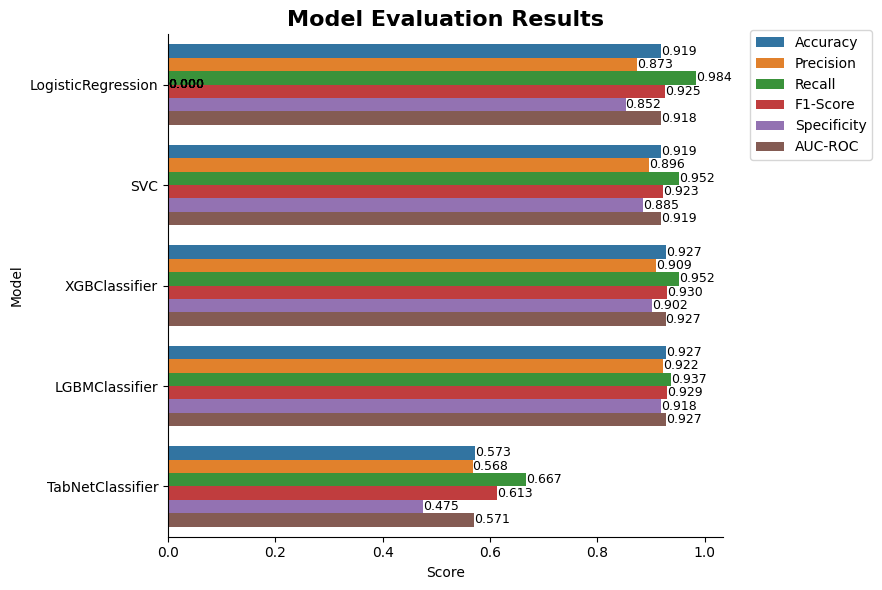

In [122]:
# Prepare data for plotting
plot_df = pd.melt(TESTING_SCORES, id_vars=["Model"])
plot_df.rename({"variable": "Metric", "value": "Score"}, axis=1, inplace=True)

PLOT = sns.catplot(
    x="Score", 
    y="Model", 
    hue="Metric", 
    data=plot_df, 
    kind="bar", 
    orient="h",
    height=6, 
    aspect=1.5, 
    legend_out=False,
    palette="tab10"  
)

# Access the axes of the plot
ax = PLOT.axes[0, 0]

# Annotate the bars with their corresponding scores
for p in ax.patches:
    ax.annotate(f"{p.get_width():.3f}", 
                (p.get_x() + p.get_width(), p.get_y() + p.get_height() / 2),
                ha="left", va="center", fontsize=9)

# Set plot title and legend
plt.title("Model Evaluation Results", fontsize=16, fontweight='bold')
plt.legend(loc=(1.05, 0.75))
plt.tight_layout()

# Display the plot
plt.show()


In [123]:
MODELS_TESTING_SCORES = pd.concat([TESTING_SCORES, TESTING_SCORES_R], axis=0)
MODELS_TESTING_SCORES

Model  Accuracy  Precision    Recall  F1-Score  Specificity  \
0    LogisticRegression  0.919355   0.873239  0.984127  0.925373     0.852459   
1                   SVC  0.919355   0.895522  0.952381  0.923077     0.885246   
2         XGBClassifier  0.927419   0.909091  0.952381  0.930233     0.901639   
3        LGBMClassifier  0.927419   0.921875  0.936508  0.929134     0.918033   
4      TabNetClassifier  0.572581   0.567568  0.666667  0.613139     0.475410   
0  LogisticRegression_R  0.927419   0.885714  0.984127  0.932331     0.868852   
1                 SVC_R  0.935484   0.923077  0.952381  0.937500     0.918033   
2       XGBClassifier_R  0.935484   0.923077  0.952381  0.937500     0.918033   
3      LGBMClassifier_R  0.919355   0.934426  0.904762  0.919355     0.934426   

    AUC-ROC  
0  0.918293  
1  0.918813  
2  0.927010  
3  0.927270  
4  0.571038  
0  0.926490  
1  0.935207  
2  0.935207  
3  0.919594

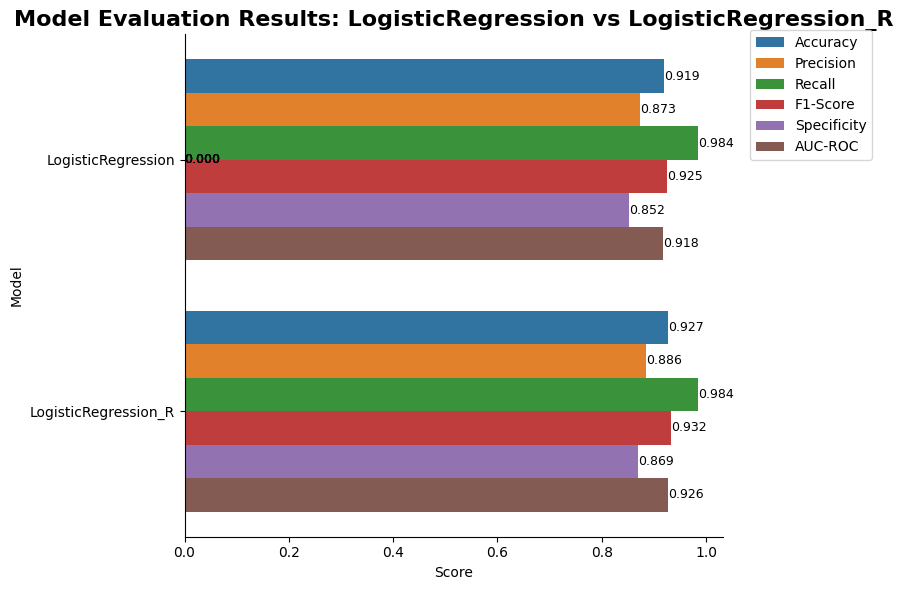

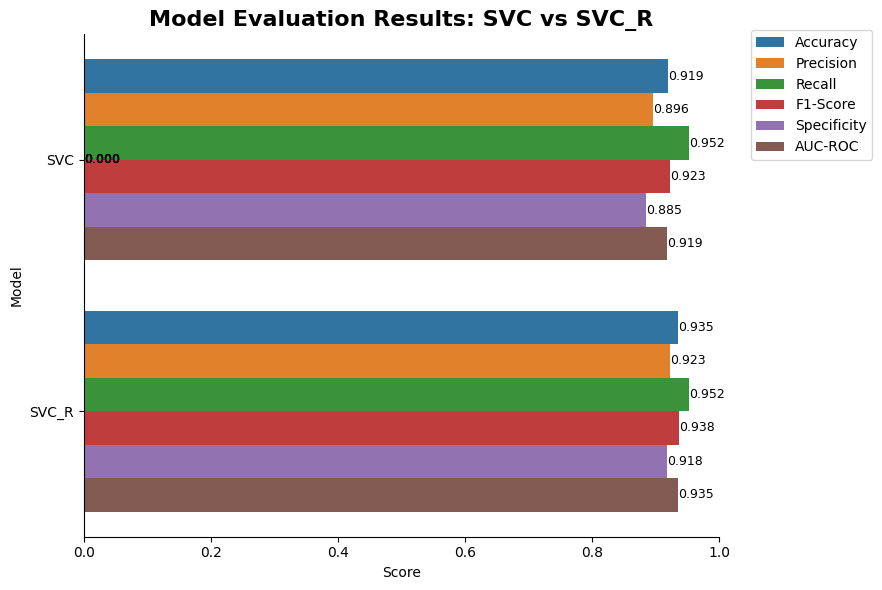

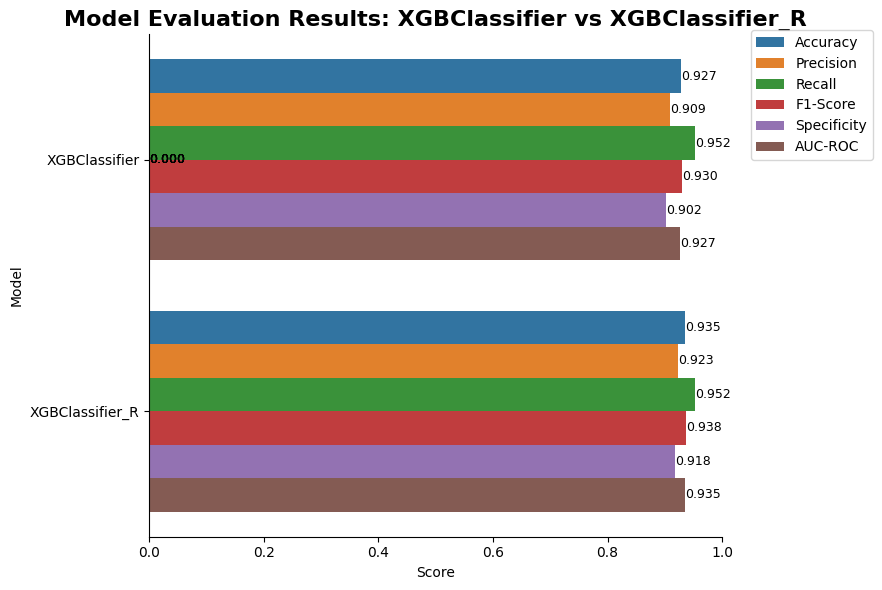

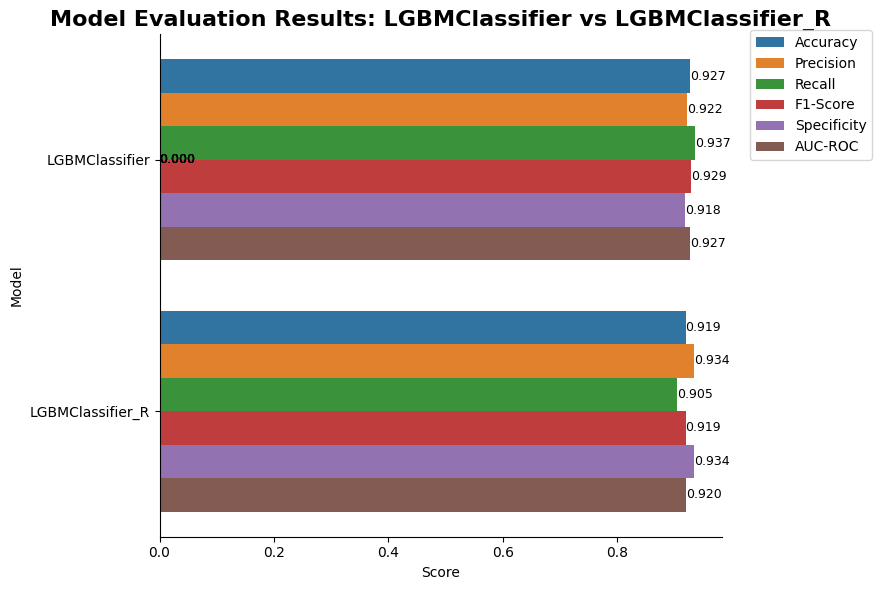

In [124]:
normal_models = TESTING_SCORES['Model'].unique()
reduced_models = TESTING_SCORES_R['Model'].unique()

# Loop through each model and its reduced counterpart
for normal_model, reduced_model in zip(normal_models, reduced_models):
    
    # Filter out the scores for the current model and its reduced counterpart
    normal_model_scores = TESTING_SCORES[TESTING_SCORES['Model'] == normal_model]
    reduced_model_scores = TESTING_SCORES_R[TESTING_SCORES_R['Model'] == reduced_model]
    
    # Combine the scores into one dataframe for plotting
    combined_scores = pd.concat([normal_model_scores, reduced_model_scores])

    # Prepare data for plotting
    plot_df = pd.melt(combined_scores, id_vars=["Model"])
    plot_df.rename({"variable": "Metric", "value": "Score"}, axis=1, inplace=True)
    
    PLOT = sns.catplot(
        x="Score", 
        y="Model", 
        hue="Metric", 
        data=plot_df, 
        kind="bar", 
        orient="h",
        height=6, 
        aspect=1.5, 
        legend_out=False,
        palette="tab10"  
    )
    
    # Access the axes of the plot
    ax = PLOT.axes[0, 0]
    
    # Annotate the bars with their corresponding scores
    for p in ax.patches:
        ax.annotate(f"{p.get_width():.3f}", 
                    (p.get_x() + p.get_width(), p.get_y() + p.get_height() / 2),
                    ha="left", va="center", fontsize=9)
    
    # Set plot title for each model and its reduced version
    plt.title(f"Model Evaluation Results: {normal_model} vs {reduced_model}", fontsize=16, fontweight='bold')
    
    # Set legend and show the plot
    plt.legend(loc=(1.05, 0.75))
    plt.tight_layout()
    plt.show()


In [125]:
# for i, model_name in enumerate(MODEL_CONTAINER_R.keys()):

#     # Retrieve the model and corresponding test data
#     model = MODEL_CONTAINER_R[model_name]
#     X_test_current = X_test_val_list[i]
    
#     # Predict on the test data
#     y_pred = model.predict(X_test_current)

#     # Generate the confusion matrix
#     cm = confusion_matrix(y_test_val, y_pred)

#     # Visualize the confusion matrix
#     disp = ConfusionMatrixDisplay(confusion_matrix=cm)
#     disp.plot(cmap=plt.cm.Blues)
#     plt.title(f"Confusion Matrix for {model_name}")
    
#     # Show the plot
#     plt.show()

In [126]:
XGB_PREDICTED_PROBA = TRAINED_XGB.predict_proba(X_test)
LGBM_PREDICTED_PROBA = TRAINED_LGBM.predict_proba(X_test)
SVM_PREDICTED_PROBA = TRAINED_SVM.predict_proba(X_test)

In [127]:
weight_xgb = 0.33
weight_lgbm = 0.33
weight_svc = 0.33

TOP3_WAVERAGE_PREDICTIONS = (weight_lgbm * LGBM_PREDICTED_PROBA + weight_xgb * XGB_PREDICTED_PROBA + weight_svc * SVM_PREDICTED_PROBA) / (weight_lgbm + weight_xgb + weight_svc)



In [128]:
TOP3_LABELED_PREDICTIONS = np.argmax(TOP3_WAVERAGE_PREDICTIONS, axis=1)

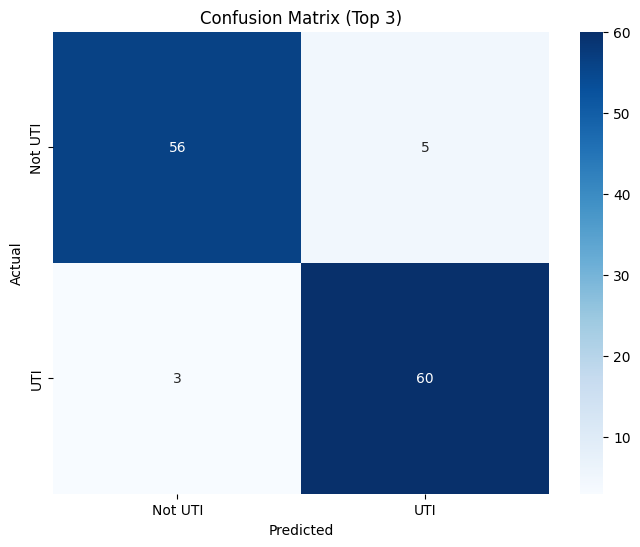

In [129]:
T2_CM = confusion_matrix(y_test, TOP3_LABELED_PREDICTIONS)

plt.figure(figsize=(8, 6))
sns.heatmap(T2_CM, annot=True, fmt="d", cmap="Blues", cbar=True,
            xticklabels=["Not UTI", "UTI"], yticklabels=["Not UTI", "UTI"])
plt.title("Confusion Matrix (Top 3)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [130]:
# Compute evaluation metrics using scikit-learn functions
T3_ACCURACY = accuracy_score(y_test, TOP3_LABELED_PREDICTIONS)
T3_F1 = f1_score(y_test, TOP3_LABELED_PREDICTIONS)
T3_RECALL = recall_score(y_test, TOP3_LABELED_PREDICTIONS)
T3_PRECISION = precision_score(y_test, TOP3_LABELED_PREDICTIONS)

# Compute additional metrics (confusion matrix, specificity, ROC AUC)
T3_TN, T3_FP, _, _ = confusion_matrix(y_test, TOP3_LABELED_PREDICTIONS).ravel()
T3_SPECIFICITY = T3_TN / (T3_TN + T3_FP)
T3_ROC_AUC = roc_auc_score(y_test, TOP3_LABELED_PREDICTIONS)

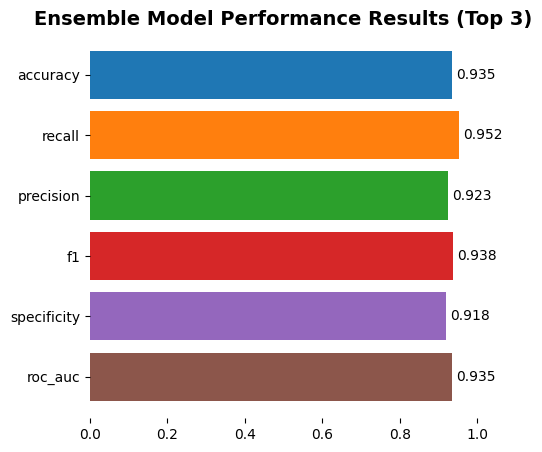

In [131]:
# Create a horizontal bar plot with specified figure size
fig, axs = plt.subplots(figsize=(5, 5))

bar_graph = axs.barh(
    ["accuracy", "recall", "precision", "f1", "specificity", "roc_auc"],
    [T3_ACCURACY, T3_RECALL, T3_PRECISION, T3_F1, T3_SPECIFICITY, T3_ROC_AUC],
    color=sns.color_palette("tab10")  
)

# Add labels to the bars with the corresponding values
axs.bar_label(bar_graph, labels=[f"{x:.3f}" for x in bar_graph.datavalues], padding=3)

# Remove spines for aesthetics
for spine in ["top", "bottom", "left", "right"]:
    axs.spines[spine].set_visible(False)

# Invert y-axis for better visualization
axs.invert_yaxis()

# Set plot title and display the plot
plt.title("Ensemble Model Performance Results (Top 3)", fontsize=14, fontweight='bold')
plt.show()


In [132]:
# Save each model
import joblib
joblib.dump(TRAINED_XGB, "trained_xgb_model.pkl")
joblib.dump(TRAINED_SVM, "trained_svm_model.pkl")
joblib.dump(TRAINED_LGBM, "trained_lgbm_model.pkl")


['trained_lgbm_model.pkl']

In [133]:
ensemble_weights = {'weight_xgb': 0.33, 'weight_lgbm': 0.33, 'weight_svc': 0.33}
joblib.dump(ensemble_weights, "ensemble_weights.pkl")

['ensemble_weights.pkl']